In [ ]:
#Neural Networks
# Backprop on the Seeds Dataset
from random import seed
from random import randrange
from random import random
from csv import reader
from math import exp
 
# Load a CSV file
def load_csv(filename):
	dataset = list()
	with open(filename, 'r') as file:
		csv_reader = reader(file)
		for row in csv_reader:
			if not row:
				continue
			dataset.append(row)
	return dataset
 
# Convert string column to float
def str_column_to_float(dataset, column):
	for row in dataset:
		row[column] = float(row[column].strip())
 
# Convert string column to integer
def str_column_to_int(dataset, column):
	class_values = [row[column] for row in dataset]
	unique = set(class_values)
	lookup = dict()
	for i, value in enumerate(unique):
		lookup[value] = i
	for row in dataset:
		row[column] = lookup[row[column]]
	return lookup
 
# Find the min and max values for each column
def dataset_minmax(dataset):
	minmax = list()
	stats = [[min(column), max(column)] for column in zip(*dataset)]
	return stats  
 
# Rescale dataset columns to the range 0-1
def normalize_dataset(dataset, minmax):
	for row in dataset:
		for i in range(len(row)-1):
			row[i] = (row[i] - minmax[i][0]) / (minmax[i][1] - minmax[i][0])
 
# Split a dataset into k folds
def cross_validation_split(dataset, n_folds):
	dataset_split = list()
	dataset_copy = list(dataset)
	fold_size = int(len(dataset) / n_folds)
	for i in range(n_folds):
		fold = list()
		while len(fold) < fold_size:
			index = randrange(len(dataset_copy))
			fold.append(dataset_copy.pop(index))
		dataset_split.append(fold)
	return dataset_split
 
# Calculate accuracy percentage
def accuracy_metric(actual, predicted):
	correct = 0
	for i in range(len(actual)):
		if actual[i] == predicted[i]:
			correct += 1
	return correct / float(len(actual)) * 100.0
 
# Evaluate an algorithm using a cross validation split
def evaluate_algorithm(dataset, algorithm, n_folds, *args):
	folds = cross_validation_split(dataset, n_folds)
	scores = list()
	for fold in folds:
		train_set = list(folds)
		train_set.remove(fold)
		train_set = sum(train_set, [])
		test_set = list()
		for row in fold:
			row_copy = list(row)
			test_set.append(row_copy)
			row_copy[-1] = None
		predicted = algorithm(train_set, test_set, *args)
		actual = [row[-1] for row in fold]
		accuracy = accuracy_metric(actual, predicted)
		scores.append(accuracy)
	return scores
 
# Calculate neuron activation for an input
def activate(weights, inputs):
	activation = weights[-1]
	for i in range(len(weights)-1):
		activation += weights[i] * inputs[i]
	return activation
 
# Transfer neuron activation
def transfer(activation):
	return 1.0 / (1.0 + exp(-activation))
 
# Forward propagate input to a network output
def forward_propagate(network, row):
	inputs = row
	for layer in network:
		new_inputs = []
		for neuron in layer:
			activation = activate(neuron['weights'], inputs)
			neuron['output'] = transfer(activation)
			new_inputs.append(neuron['output'])
		inputs = new_inputs
	return inputs
 
# Calculate the derivative of an neuron output
def transfer_derivative(output):
	return output * (1.0 - output)
 
# Backpropagate error and store in neurons
def backward_propagate_error(network, expected):
	for i in reversed(range(len(network))):
		layer = network[i]
		errors = list()
		if i != len(network)-1:
			for j in range(len(layer)):
				error = 0.0
				for neuron in network[i + 1]:
					error += (neuron['weights'][j] * neuron['delta'])
				errors.append(error)
		else:
			for j in range(len(layer)):
				neuron = layer[j]
				errors.append(neuron['output'] - expected[j])
		for j in range(len(layer)):
			neuron = layer[j]
			neuron['delta'] = errors[j] * transfer_derivative(neuron['output'])
 
# Update network weights with error
def update_weights(network, row, l_rate):
	for i in range(len(network)):
		inputs = row[:-1]
		if i != 0:
			inputs = [neuron['output'] for neuron in network[i - 1]]
		for neuron in network[i]:
			for j in range(len(inputs)):
				neuron['weights'][j] -= l_rate * neuron['delta'] * inputs[j]
			neuron['weights'][-1] -= l_rate * neuron['delta']
 
# Train a network for a fixed number of epochs
def train_network(network, train, l_rate, n_epoch, n_outputs):
	for epoch in range(n_epoch):
		for row in train:
			outputs = forward_propagate(network, row)
			expected = [0 for i in range(n_outputs)]
			expected[row[-1]] = 1
			backward_propagate_error(network, expected)
			update_weights(network, row, l_rate)
 
# Initialize a network
def initialize_network(n_inputs, n_hidden, n_outputs):
	network = list()
	hidden_layer = [{'weights':[random() for i in range(n_inputs + 1)]} for i in range(n_hidden)]
	network.append(hidden_layer)
	output_layer = [{'weights':[random() for i in range(n_hidden + 1)]} for i in range(n_outputs)]
	network.append(output_layer)
	return network
 
# Make a prediction with a network
def predict(network, row):
	outputs = forward_propagate(network, row)
	return outputs.index(max(outputs))
 
# Backpropagation Algorithm With Stochastic Gradient Descent
def back_propagation(train, test, l_rate, n_epoch, n_hidden):
	n_inputs = len(train[0]) - 1
	n_outputs = len(set([row[-1] for row in train]))
	network = initialize_network(n_inputs, n_hidden, n_outputs)
	train_network(network, train, l_rate, n_epoch, n_outputs)
	predictions = list()
	for row in test:
		prediction = predict(network, row)
		predictions.append(prediction)
	return(predictions)
 
dataset = [[2.7810836,2.550537003,0],
	[1.465489372,2.362125076,0],
	[3.396561688,4.400293529,0],
	[1.38807019,1.850220317,0],
	[3.06407232,3.005305973,0],
	[7.627531214,2.759262235,1],
	[5.332441248,2.088626775,1],
	[6.922596716,1.77106367,1],
	[8.675418651,-0.242068655,1],
	[7.673756466,3.508563011,1]]


# normalize input variables
minmax = dataset_minmax(dataset)
normalize_dataset(dataset, minmax)
# evaluate algorithm
n_folds = 5
l_rate = 1
n_epoch = 500
n_hidden = 5
scores = evaluate_algorithm(dataset, back_propagation, n_folds, l_rate, n_epoch, n_hidden)
print('Scores: %s' % scores)
print('Mean Accuracy: %.3f%%' % (sum(scores)/float(len(scores))))

In [ ]:
pip install creme

     |████████████████████████████████| 1.1 MB 5.1 MB/s 
  Created wheel for mmh3: filename=mmh3-2.5.1-cp37-cp37m-linux_x86_64.whl size=39665 sha256=de62f441e169105fc24b9a27a3723d10fe938d7f4227bbdc1e432073370464af
  Stored in directory: /root/.cache/pip/wheels/ae/45/25/90e097a519143b2dca74cd93a056894a965f27908103e01799
Successfully built mmh3


In [ ]:
import math
from creme import compose
from creme import datasets
from creme import linear_model
from creme import metrics
from creme import preprocessing
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import random_split
from sklearn.model_selection import train_test_split


In [ ]:
#dataset

df = pd.read_csv("https://raw.githubusercontent.com/RushiPardeshi/Machine-Learning/main/owid-covid-data%20(1).csv")
new_data = df[df['location']=='India']
# new_data
da = pd.read_csv('https://raw.githubusercontent.com/RushiPardeshi/Machine-Learning/main/changes-visitors-covid.csv')
indian_visitor = da[da['Entity']=='India']
# indian_visitor
target = new_data[['date','new_cases']]
target = target.rename({'date':'Day'},axis=1)
# target
final = pd.merge(indian_visitor,target,on='Day')
final = final.drop(['Entity','Code','Day'],axis=1)
# print(final)
dataset = final

train_no = int(len(dataset)*0.8)
test_no = len(dataset) - train_no
# train_ds, test_ds = random_split(dataset,[train_no,test_no])

# X = final.iloc[:, :-1].values
# Y = final.iloc[:, -1].values.reshape(-1,1)
trainx_ds, testx_ds, trainy_ds, testy_ds = train_test_split(X, Y, test_size = 0.2, random_state = 41) 
mid_index = len(trainx_ds)//2
Ax_ds = trainx_ds[:mid_index]
Bx_ds = trainx_ds[mid_index:]
Ay_ds = trainy_ds[:mid_index]
By_ds = trainy_ds[mid_index:]


# trainA_ds , testA_ds = A_ds.drop(columns = 'new_cases').copy(), A_ds['new_cases'].copy()
# trainB_ds, testB_ds = B_ds.drop(columns = 'new_cases').copy(), B_ds['new_cases'].copy()

In [ ]:
from torch.utils.data import Dataloader
batch_size = 8

trainA_loader = Dataloader(Ax_ds, batch_size, shuffle = True)
trainB_loader = Dataloader(Bx_ds, batch_size, shuffle = True)

#MNIST

In [ ]:
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
dataset = MNIST(root='data/', download=True)
test_dataset = MNIST(root='data/', train=False)
import torchvision.transforms as transforms
dataset = MNIST(root='data/', 
                train=True,
                transform=transforms.ToTensor())

In [ ]:
from torch.utils.data import random_split
trainA_ds, trainB_ds, val_ds = random_split(dataset, [20000,20000,20000])
# trainA_ds = train_ds[mid_index:]
# trainB_ds = train_ds[:mid_index]


In [ ]:
from torch.utils.data import DataLoader

batch_size = 128

trainA_loader = DataLoader(trainA_ds, batch_size, shuffle=True)
trainB_loader = DataLoader(trainB_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

In [ ]:
type(val_loader)

torch.utils.data.dataloader.DataLoader

In [ ]:
for images, labels in trainA_loader:
    inputs = images.reshape(-1, 784)
    break

In [ ]:
inputs

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [ ]:
input_size = inputs.shape[-1]
hidden_size = 32
print(inputs.shape[-1])

784


In [ ]:
layer1 = nn.Linear(input_size, hidden_size)

In [ ]:
layer1_outputs = layer1(inputs)

In [ ]:
layer1_outputs_direct = inputs @ layer1.weight.t() + layer1.bias
layer1_outputs_direct.shape

torch.Size([128, 32])

In [ ]:
torch.allclose(layer1_outputs, layer1_outputs_direct, 1e-3)

True

In [ ]:
relu_outputs = F.relu(layer1_outputs)

In [ ]:
output_size = 10
layer2 = nn.Linear(hidden_size, output_size)

In [ ]:
layer2_outputs = layer2(relu_outputs)
print(layer2_outputs.shape)

torch.Size([128, 10])


In [ ]:
F.cross_entropy(layer2_outputs, labels)

tensor(2.3174, grad_fn=<NllLossBackward0>)

In [ ]:
outputs = (F.relu(inputs @ layer1.weight.t() + layer1.bias)) @ layer2.weight.t() + layer2.bias

In [ ]:
torch.allclose(outputs, layer2_outputs, 1e-3)

True

In [ ]:
outputs2 = (inputs @ layer1.weight.t() + layer1.bias) @ layer2.weight.t() + layer2.bias

In [ ]:
combined_layer = nn.Linear(input_size, output_size)

combined_layer.weight.data = layer2.weight @ layer1.weight
combined_layer.bias.data = layer1.bias @ layer2.weight.t() + layer2.bias

In [ ]:
outputs3 = inputs @ combined_layer.weight.t() + combined_layer.bias

In [ ]:
outputs3

tensor([[-0.1674,  0.0675,  0.2295,  ..., -0.0714, -0.2120,  0.1254],
        [ 0.0397, -0.0082,  0.1787,  ..., -0.2840, -0.1763,  0.1304],
        [-0.0783,  0.0832,  0.1342,  ..., -0.0353,  0.0729,  0.0523],
        ...,
        [-0.3132,  0.2564,  0.0424,  ..., -0.0537, -0.2555, -0.1194],
        [-0.1594,  0.1057,  0.0376,  ..., -0.0995, -0.1020,  0.0136],
        [-0.2647,  0.1984,  0.2668,  ..., -0.1737, -0.1585, -0.1450]],
       grad_fn=<AddBackward0>)

In [ ]:
class MnistModel(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        # hidden layer
        self.linear1 = nn.Linear(in_size, hidden_size)
        # output layer
        self.linear2 = nn.Linear(hidden_size, out_size)
        
    def forward(self, xb):
        # Flatten the image tensors
        xb = xb.view(xb.size(0), -1)
        # Get intermediate outputs using hidden layer
        out = self.linear1(xb)
        # Apply activation function
        out = F.relu(out)
        # Get predictions using output layer
        out = self.linear2(out)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [ ]:
model = MnistModel(input_size, hidden_size=hidden_size, out_size=num_classes)

In [ ]:
def evaluate(model, val_loader):
    # Evaluate the model's performance on the validation set
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

l=[]

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    # Train the model using gradient descent
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            l.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

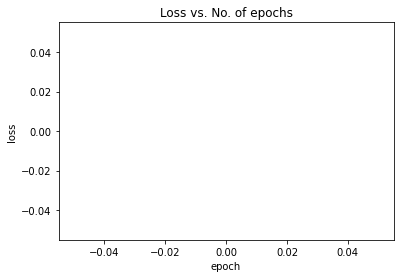

In [ ]:
losses = l
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
input_size = 784
hidden_size = 28
num_classes = 10

In [ ]:
history = [evaluate(model, val_loader)]
history

[{'val_acc': 0.1089271530508995, 'val_loss': 2.308455228805542}]

In [ ]:
history += fit(10, 0.5, model, trainA_loader, val_loader)

Epoch [0], val_loss: 0.2088, val_acc: 0.9364
Epoch [1], val_loss: 0.1641, val_acc: 0.9510
Epoch [2], val_loss: 0.1751, val_acc: 0.9520
Epoch [3], val_loss: 0.1395, val_acc: 0.9596
Epoch [4], val_loss: 0.1714, val_acc: 0.9501
Epoch [5], val_loss: 0.1549, val_acc: 0.9570
Epoch [6], val_loss: 0.3999, val_acc: 0.8843
Epoch [7], val_loss: 0.1615, val_acc: 0.9555
Epoch [8], val_loss: 0.2229, val_acc: 0.9376
Epoch [9], val_loss: 0.2027, val_acc: 0.9464


In [ ]:
w = model.parameters()

In [ ]:
# for p in model.parameters():
#   if p.requires_grad:
#     print(p.name,p.data)

In [ ]:
history += fit(5, 0.5, model, trainB_loader, val_loader)

Epoch [0], val_loss: 0.1985, val_acc: 0.9383
Epoch [1], val_loss: 0.1745, val_acc: 0.9487
Epoch [2], val_loss: 0.1743, val_acc: 0.9488
Epoch [3], val_loss: 0.1609, val_acc: 0.9516
Epoch [4], val_loss: 0.1446, val_acc: 0.9570


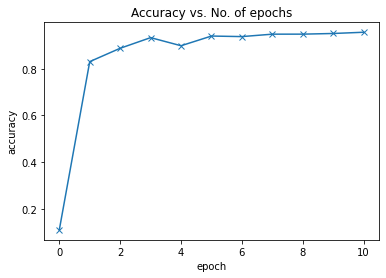

In [ ]:
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

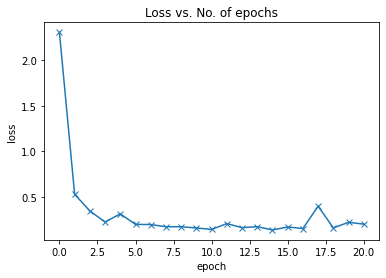

In [ ]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');